# CM30359 Reinforcement Learning

## Monte Carlo Methods
In this lab session, we will be guiding you through implementing one of the Monte Carlo control algorithms discussed in this week's lectures and applying it to solve a simple sequential decision problem.

Specifically, you will implement the On-Policy First-Visit Monte-Carlo Control algorithm and use it to train an agent to drive a car around a simple simulated racetrack.

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this lab. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods. It is worth noting that tuples can be used to index certain Python data-structures, such as dictionaries.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


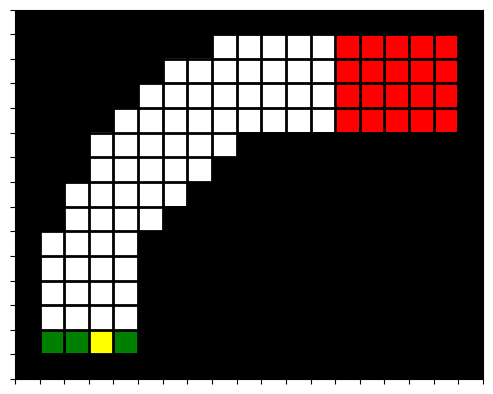

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print(env.get_actions())
print("Initial State: {}".format(state))

As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

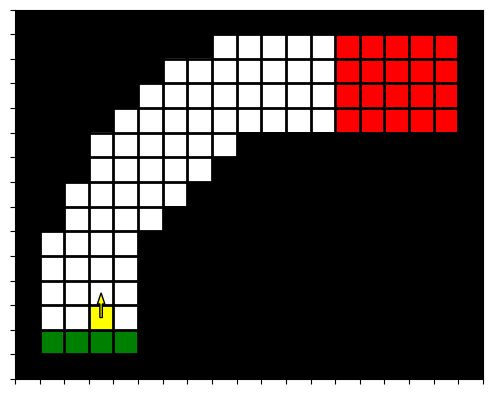

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [2]:
# Let us increase the agent's vertical speed (action 1).
terminal = False
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

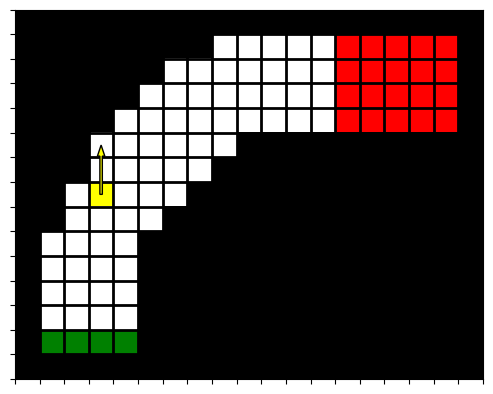

In [6]:
num_steps = 3
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise: On-Policy MC Control

### Instructions
In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using On-Policy First-Visit MC Control, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 5.4 p.101).

<img src="images/mc_control_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

Your implementation of a tabular **On-Policy First-Visit MC Control** agent should produce a list named `mc_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `mc_rewards` list will contain $20$ sub-lists, each containing $150$ integers. Below your implementation, we will use this list to plot a **learning curve**, which shows the average return earned by your agents each episode.

### Getting Started
If you are having trouble implementing the pseudocode shown above, here are some hints to help you get started:
- Monte Carlo agents work by generating full episodes of experience, and then making updates based on the states visited, actions taken, and rewards earned during those episodes. As such, it would make sense for your code to consist of two parts:
    - One which generates an episode of experience.
    - One which takes an episode of experience and performs updates based on it.
- Python has many datastructures that could be useful for implementing RL agents.
    - Dictionaries can be useful for representing your agent's Q-table, as they allow mappings from keys (state-action pairs) to values (action values).
    - Tuples can be useful for storing the experience your agent generates each time-step (state, action, reward, next-state).

In [3]:
#Create Q table
def create_q_table():
    q = {
        (a, b, c, d): {k: 0 for k in range(9)}
        for a in range(1, 18)
        for b in range(1, 14)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return q
def init_epsilon_policy(n_actions):
    policy={
        (a, b, c, d): {k: 1/n_actions for k in range(9)}
        for a in range(1, 18)
        for b in range(1, 14)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return policy



In [18]:
# On policy first visit MC control for e-soft policies

def generate_episode(env, policy, n_actions=9, epsilon=0.15,visual=False):
    state = env.reset()
    episode = []
    while True:
        action = np.random.choice(np.arange(n_actions), p=np.array(list(policy[state].values())))
        next_state, reward, terminal = env.step(action)
        episode.append((state, action, reward, terminal))
        state = next_state
        if visual:
            env.render()
        if terminal:
            break
    return episode
def check_tuple(tuple,list):
    for t in list:
        if t[0]==tuple[0] and t[1]==tuple[1]:
            return True
    return False
def monte_carlo_control(env,q,policy, num_episodes=150, gamma=0.9, epsilon=0.15):
    returns = {
    (a, b, c, d): {k: [] for k in range(9)}
    for a in range(1, 18)
    for b in range(1, 14)
    for c in range(-10, 11)
    for d in range(-10, 11)
                }
    rewards=[]
    for i in range(num_episodes):
        visual=False
        if i in [36,50,111,123,150]:
            visual=True
        actions=env.get_actions()
        episode = generate_episode(env, policy,len(actions), epsilon,visual)
        g=0
        
        rewards.append(sum([st[2] for st in episode]))
        for t in reversed(range(len(episode))):
            state, action, reward, terminal = episode[t]
            g = gamma * g + reward
            if not check_tuple((state,action),episode[:t]):
                returns[state][action].append(g)
                q[state][action] = np.mean(returns[state][action])
                a_star= max(q[state], key=q[state].get)
                for action in q[state].keys():
                    if action!=a_star:
                        policy[state][action]=epsilon/9
                    else:
                        policy[state][action]=1-epsilon+epsilon/9
    return q, policy, reward

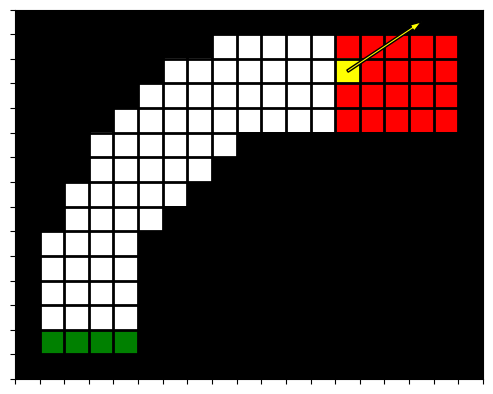

In [19]:
env.reset()
q=create_q_table()
policy=init_epsilon_policy(n_actions=9)
q,policy,rewards=monte_carlo_control(env,q,policy)

#macarroni

In [17]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent here.
# Do NOT delete this cell.

# YOUR CODE HERE
mc_rewards=[]
num_agents=20
for agent in range(num_agents):
    env.reset()
    q=create_q_table()
    policy=init_epsilon_policy(n_actions=9)
    q,policy,reward=monte_carlo_control(env,q,policy)
    mc_rewards.append(reward)

In [18]:
mc_rewards

[[-4612,
  -21554,
  -2888,
  -787,
  -44,
  -1364,
  -6929,
  -2740,
  -1075,
  -4196,
  -1422,
  -847,
  -2605,
  -659,
  -2740,
  -1330,
  -711,
  -40,
  -194,
  -166,
  -319,
  -1026,
  -121,
  -230,
  -81,
  -92,
  -235,
  4,
  -80,
  -15,
  -390,
  -134,
  -317,
  -55,
  -32,
  -47,
  -158,
  -41,
  -151,
  4,
  -197,
  -14,
  -202,
  -70,
  -31,
  -48,
  -119,
  -99,
  -219,
  -26,
  2,
  -29,
  -14,
  -48,
  -234,
  -2,
  -146,
  -13,
  -21,
  -34,
  -360,
  -39,
  -158,
  -99,
  0,
  -84,
  -41,
  -30,
  -152,
  -82,
  -2,
  -106,
  -189,
  -215,
  1,
  -230,
  -117,
  2,
  -2,
  -19,
  -58,
  -28,
  -35,
  -27,
  -52,
  -18,
  0,
  -118,
  -114,
  -65,
  3,
  -65,
  -40,
  -126,
  -146,
  -14,
  -114,
  -147,
  -105,
  -74,
  -157,
  -2,
  -31,
  -57,
  -51,
  -268,
  -1,
  -19,
  -56,
  -34,
  -68,
  -60,
  -114,
  2,
  -153,
  -12,
  2,
  -27,
  -42,
  -28,
  0,
  -171,
  -29,
  -47,
  1,
  -23,
  -54,
  -4,
  -1,
  -14,
  -25,
  -34,
  -68,
  -92,
  -43,
  -1,
  -63,
  -69

### Plotting a Learning Curve

Below, we call a function that takes your `mc_rewards` list and uses it to plot a learning curve. This graph shows the average undiscounted return earned by your agents each episode.

We have included results from a correct implementation to compare your results to. Your learning curve should be close to this example one, but do not worry it does not match it exactly as there will naturally be some variation during training.

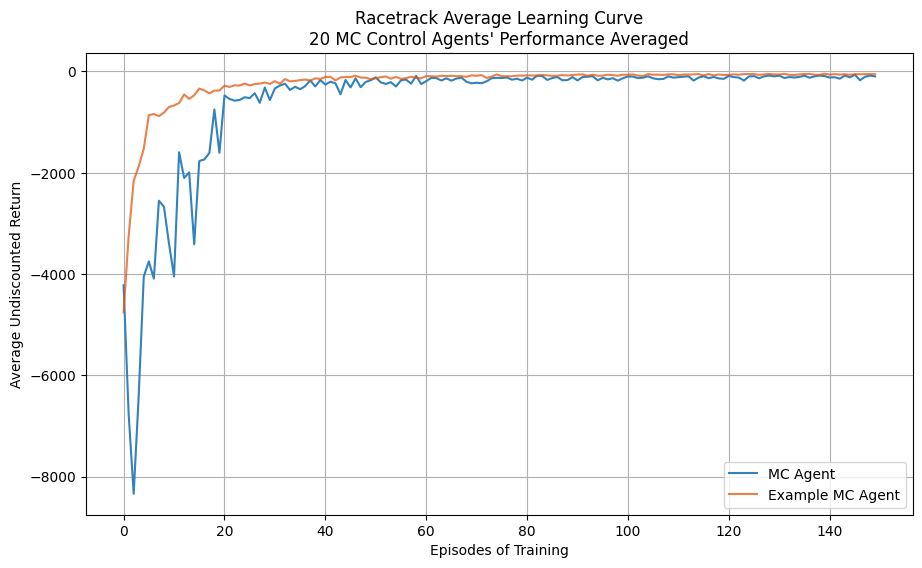

In [19]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking MC Control Results for Obvious Issues.
simple_issue_checking(mc_rewards)

# Plotting MC Control Learning Curve.
%matplotlib inline
plot_results(mc_rewards = mc_rewards)